add story here

add

add

add

add

at some point remember to mention that using open street map in searches gets you better results because it respects city limits


The storyline is about moving to california somewhere near the coast 







In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim 
import folium
from folium import plugins
from folium.plugins import HeatMap
import requests
import json
from matplotlib import pyplot as plt 
import seaborn as sns
import time 
from sklearn.cluster import KMeans 
from sklearn.cluster import MeanShift
from sklearn.datasets import make_blobs
from geopy import distance

<h1> Importing and cleaning data </h1>

add

add

also something about how at each stage the data is used to reduce the number of potential cities 

add

add

<h2> Census data </h2> 

<p> The first step in the analysis will be identifying cities where our friends could open their pizza place. We know that they'd like to relocate somewhere in California and avoid cities with less than 200k inhabitants.</p> 

<p> The best place to get a complete list of potential location is the California Census. This data is publicly available for download as an xlsx file and allows us to easily filter cities by population. </p>

<p> The main challenge will be data cleaning. An initial step has already been taken by removing all unnecessary columns directly in Excel. The next step will include removing county-level totals, empty lines, the "city" and "CPD" suffixes as well as the numerous unneeded spaces placed before and after text strings.</p>

In [2]:
census=pd.read_excel('CensusData/census.xlsx')
census.head()

Geography  Total population
0                NaN               NaN
1     Alameda County         1510271.0
2      Alameda city            73812.0
3       Albany city            18539.0
4       Ashland CDP            21925.0

In [3]:
census.shape

(1643, 2)

In [4]:
census.dropna(inplace=True) #deleting empty lines
census.shape

(1585, 2)

In [5]:
census.columns #checking column names 

Index(['Geography', 'Total population'], dtype='object')

In [6]:
census.rename(columns={'Geography':'location','Total population':'population'}, inplace=True) #renaming columns
census.head()

location  population
1      Alameda County   1510271.0
2       Alameda city      73812.0
3        Albany city      18539.0
4        Ashland CDP      21925.0
5      Berkeley city     112580.0

In [7]:
county_filter=~census['location'].str.contains('County') #creating a filter to eliminate rows with the count totals
census=census[county_filter]
census.head()

location  population
2           Alameda city      73812.0
3            Albany city      18539.0
4            Ashland CDP      21925.0
5          Berkeley city     112580.0
6      Castro Valley CDP      61388.0

In [8]:
census['location']=census['location'].str.replace('CDP','')   #removing the CDP suffix
census.head()

location  population
2        Alameda city      73812.0
3         Albany city      18539.0
4            Ashland       21925.0
5       Berkeley city     112580.0
6      Castro Valley       61388.0

In [9]:
census['location']=census['location'].str.replace('city','')  #removing the city suffix
census.head()

location  population
2            Alameda       73812.0
3             Albany       18539.0
4            Ashland       21925.0
5           Berkeley      112580.0
6      Castro Valley       61388.0

In [10]:
census['location']=census['location'].str.replace('town','')  #removing the town suffix
census.head()

location  population
2            Alameda       73812.0
3             Albany       18539.0
4            Ashland       21925.0
5           Berkeley      112580.0
6      Castro Valley       61388.0

In [11]:
census.dtypes #checking that the dataypes are correct 

location       object
population    float64
dtype: object

In [12]:
census.shape

(1527, 2)

In [13]:
#the location column is plagued with extra spaces at the beginning and ending of strings (probably placed for aestetic purposes in the original database)
#we can see an example by testing one of the location names 
census.loc[5,'location']

'    Berkeley  '

In [14]:
census['location']=census['location'].str.strip()  #removing the spaces
census.loc[5,'location'] #and testing it on one of the names

'Berkeley'

<h3> Filtering by population size </h3>

<p> One of the requirements for the location is to have at least 200.000 people. </p> 

In [15]:
Pop_filter=(census['population']>=200000) #creating a filter 
census=census[Pop_filter] 
census.shape

(18, 2)

In [16]:
census.reset_index(inplace=True, drop=True) #resetting the index after filterting the df 
census.head()

location  population
0      Fremont    214089.0
1      Oakland    390724.0
2       Fresno    494665.0
3  Bakersfield    347483.0
4   Long Beach    462257.0

<h3>Adding coordinates and visualizing data </h3>

<h4> Getting geo data </h4>

In [17]:
latitude=[] #creating an empty list to store latitude
longitude=[] #creating an empty list to store longitude
location=[] #creating an empty list to store location names

for city in census['location']:
    geolocator=Nominatim(user_agent='census_searcher')
    loc=geolocator.geocode('{} California'.format(city)) #building a search string and adding the word California to city names to help avoid problems with similarly name cities in other parts of the world
    if loc is None:  
        print("couldn't find", city)  #adding this to catch any issues with cities that couldn't be found by Nominatim 
    else:
        latitude.append(loc.latitude) #adding latitude to the list 
        longitude.append(loc.longitude) #adding longitude to the list
        location.append(city)
    
coordinates=pd.DataFrame({'location':location, 'latitude':latitude, 'longitude':longitude})     
coordinates.head()

location   latitude   longitude
0      Fremont  37.548270 -121.988572
1      Oakland  37.804456 -122.271356
2       Fresno  36.729529 -119.708861
3  Bakersfield  35.373871 -119.019464
4   Long Beach  33.769016 -118.191605

In [18]:
coordinates.shape #checking if the dataframe has the same number of rows as the census one 

(18, 3)

In [19]:
potential_locations=pd.merge(census,coordinates) #merging the coordinates df to the census one

In [20]:
potential_locations.shape #checking if the number of rows and coulumns is the correct one 

(18, 4)

In [21]:
potential_locations.head()

location  population   latitude   longitude
0      Fremont    214089.0  37.548270 -121.988572
1      Oakland    390724.0  37.804456 -122.271356
2       Fresno    494665.0  36.729529 -119.708861
3  Bakersfield    347483.0  35.373871 -119.019464
4   Long Beach    462257.0  33.769016 -118.191605

<h4> Creating a map </h4>

In [22]:
#getting the coordinates for the center of California to create a map
geolocator= Nominatim(user_agent='California_finder') #setting up geolocator
cali_location=geolocator.geocode('California')        #searching for California
cali_lat= cali_location.latitude                      #extracting latitude
cali_long=cali_location.longitude                     #extracting longitude 

#creating an empty map first
locations_map=folium.Map(location=[cali_lat, cali_long], zoom_start=6, tiles='Stamen Terrain')
locations_map

In [23]:
#adding locations to the map
for lat, long, name, pop in zip(potential_locations['latitude'], potential_locations['longitude'], potential_locations['location'], potential_locations['population']):
    label='{}, population: {}'.format(name,pop)
    label= folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill= True, 
    parse_html=False).add_to(locations_map)
    
locations_map

<h4> Observation </h4>

<p> Looking at the map it is interesting to note how some large cities like Los Angeles are actually composed of many smaller cities that have joined. This will be important to keep in mind when looking at competition since when two cities end up merging users will have equal access to the pizza places of both cities </p>

<h2> Search interest </h2> 

<p>Knowing the population is useful but, since not everyone is interested in pizza, doesn't tell us much about the potential of each location.  The ideal solution would be to conduct surveys in each location to gauge local interest but this would be prohibitively expensive for a family business and very time-consuming. </p>

<p>An alternative solution is to use freely available data from Google Trends to compare the search levels for the keyword pizza in each location. </p>

<h4> Understanding Google Trends data </h4> 

<p>The challenge is that the page uses a tree-structure that makes it impossible to view detailed data for more than one geographical area at a time. For this reason, it is possible to compare the intensity of searches between metropolitan areas of the same state, and between cities of the same metropolitan area, but it is not possible to directly compare cities located in different metropolitan areas.</p>

<p>The page does offer a city-level view but this view only shows a limited number of cities. In the case of California, a state-level search would only return 50.</p>
<p> To get around this problem it was decided to first obtain the score of each metropolitan area of California and then those for every city within each metropolitan area. The scores of each city will then be weighted using the score of their metropolitan area to get data that is directly comparable. This method delivered data for 370 cities.</p>

<p>NOTE: Google also displays the variation of data over time but in this particular case the search volume was stable over time and the average value for the past year was used</p>

<h3> State-level data </h3>
<p> This data shows the search interest in each metropolitan-area (as defined by Google) of the state of California </p>

In [24]:
Google_metro=pd.read_csv('SearchData/MetropolitanData.csv')
Google_metro.reset_index(inplace=True)
Google_metro.head()

index Categoria: Tutte le categorie
0                             DMA  pizza: (07/05/19 - 07/05/20)
1                  Bakersfield CA                           100
2                       Eureka CA                            92
3  Sacramento-Stockton-Modesto CA                            89
4               Fresno-Visalia CA                            88

In [25]:
Google_metro.drop([0], inplace=True) #dropping the line we don't need
Google_metro.head()

index Categoria: Tutte le categorie
1                  Bakersfield CA                           100
2                       Eureka CA                            92
3  Sacramento-Stockton-Modesto CA                            89
4               Fresno-Visalia CA                            88
5                Chico-Redding CA                            87

In [26]:
Google_metro.columns=['metro_area','metro_score'] #renaming the columns 
Google_metro.head()

metro_area metro_score
1                  Bakersfield CA         100
2                       Eureka CA          92
3  Sacramento-Stockton-Modesto CA          89
4               Fresno-Visalia CA          88
5                Chico-Redding CA          87

In [27]:
Google_metro.dtypes  #checking datatypes

metro_area     object
metro_score    object
dtype: object

In [28]:
Google_metro['metro_score']=Google_metro['metro_score'].astype('int64') #casting the score to int
Google_metro.dtypes 

metro_area     object
metro_score     int64
dtype: object

<h3>Importing and cleaning data for each Metropolitan area</h3>
<p> NOTE: since all Google datasets were obtained in the same way I will apply the data cleaning process to all of them but do so in a single cell </p>

In [29]:
Bakersfield=pd.read_csv('SearchData/1_Bakersfield.csv')
Bakersfield.reset_index(inplace=True) #resetting the index - the original one creates problems
Bakersfield.drop([0], inplace=True) #deleting an unneeded line
Bakersfield.columns=['city','original_score']
Bakersfield['original_score']=Bakersfield['original_score'].astype('int64')
Bakersfield.head()

city  original_score
1       Delano             100
2        Wasco              88
3  Bakersfield              82
4    McFarland              81
5        Arvin              76

Since the ultimate goal is to merge all the local dataframe into a single one, it will be useful to add a metropolitan area column to the dataframe to help distinguish cities with the same name. 

In [30]:
Bakersfield['metro_area']='Bakersfield'
Bakersfield.head()

city  original_score   metro_area
1       Delano             100  Bakersfield
2        Wasco              88  Bakersfield
3  Bakersfield              82  Bakersfield
4    McFarland              81  Bakersfield
5        Arvin              76  Bakersfield

Since we will need to know the weighted score we can add a new column that multiples the original score by the weight. The weight is the score for the metropolitan area divided by 100

In [31]:
Bakersfield['weighted_score']=Bakersfield['original_score']*(Google_metro.loc[1,'metro_score']/100)
Bakersfield.head() #note, in this case nothing very exciting happens because the weight just so happens to be 1 

city  original_score   metro_area  weighted_score
1       Delano             100  Bakersfield           100.0
2        Wasco              88  Bakersfield            88.0
3  Bakersfield              82  Bakersfield            82.0
4    McFarland              81  Bakersfield            81.0
5        Arvin              76  Bakersfield            76.0

In [32]:
Bakersfield.drop(columns=['original_score'],inplace=True) #the original score coulumn is no longer needed so we can drop it
Bakersfield.head()

city   metro_area  weighted_score
1       Delano  Bakersfield           100.0
2        Wasco  Bakersfield            88.0
3  Bakersfield  Bakersfield            82.0
4    McFarland  Bakersfield            81.0
5        Arvin  Bakersfield            76.0

<h4>Creating a function to make importing easier</h4>
Since this process is likely to be very repetitive and the format of all the source files and file names is standardised it is easy to create a function that takes as an argument the name of the area and it's position in the list

In [33]:
def Import_Clean (Order,Place):
    filename='SearchData/{}_{}.csv'.format(Order,Place)   #generating the filename
    temp_df=pd.read_csv(filename)  #importing the csv
    temp_df.reset_index(inplace=True) #resetting the index
    temp_df.drop([0], inplace=True) #dropping first row
    temp_df.columns=['city','original_score'] #renaming columns
    temp_df['original_score']=temp_df['original_score'].astype('int64') #casting score type
    temp_df['metro_area']=Place #adding a column to keep track of the metro area
    weight=Google_metro.loc[Order,'metro_score']/100 #calculating weight
    temp_df['weighted_score']=temp_df['original_score']*weight #adding weighted score column
    temp_df.drop(columns=['original_score'],inplace=True) #dropping original score colunn 
    return temp_df

In [34]:
#testing the function
Eureka=Import_Clean(2,'Eureka')
Eureka.head(10)

city metro_area  weighted_score
1     Hydesville     Eureka           92.00
2         Eureka     Eureka           69.92
3         Arcata     Eureka           68.08
4  McKinleyville     Eureka           58.88

In [35]:
#importing all the other CSVs

Sacramento=Import_Clean(3,'Sacramento')
Fresno=Import_Clean(4,'Fresno')
Chico=Import_Clean(5,'Chico')
PalmSprings=Import_Clean(6,'PalmSprings')
SantaBarbara=Import_Clean(7,'SantaBarbara')
LosAngeles=Import_Clean(8,'LosAngeles')
SanDiego=Import_Clean(9,'SanDiego')
Monterey=Import_Clean(10,'Monterey')
SanFrancisco=Import_Clean(11,'SanFrancisco')
Yuma=Import_Clean(12,'Yuma')

<h4> Merging local data into a single df </h4>

In [36]:
#merging them into a single df
California=pd.concat([Bakersfield,Eureka,Sacramento,Fresno,Chico,PalmSprings,SantaBarbara,LosAngeles,SanDiego,Monterey,SanFrancisco,Yuma])
California.reset_index
California.head(10)

city   metro_area  weighted_score
1         Delano  Bakersfield          100.00
2          Wasco  Bakersfield           88.00
3    Bakersfield  Bakersfield           82.00
4      McFarland  Bakersfield           81.00
5          Arvin  Bakersfield           76.00
6        Shafter  Bakersfield           69.00
1     Hydesville       Eureka           92.00
2         Eureka       Eureka           69.92
3         Arcata       Eureka           68.08
4  McKinleyville       Eureka           58.88

In [37]:
California.shape

(370, 3)

In [38]:
California.rename(columns={'weighted_score':'search_score'}, inplace=True)  #changing the name of the column to make clear what it contains 
California.head()

city   metro_area  search_score
1       Delano  Bakersfield         100.0
2        Wasco  Bakersfield          88.0
3  Bakersfield  Bakersfield          82.0
4    McFarland  Bakersfield          81.0
5        Arvin  Bakersfield          76.0

In [39]:
California.dtypes #checking if the data types are correct 

city             object
metro_area       object
search_score    float64
dtype: object

<h3> Adding search interest data to potential locations and cleaning up the dataframe </h3>

In [40]:
potential_locations=pd.merge(potential_locations,California, left_on='location', right_on='city', how='inner') #merging the dataframes
potential_locations.head()

location  population   latitude   longitude         city    metro_area  \
0      Fremont    214089.0  37.548270 -121.988572      Fremont  SanFrancisco   
1      Oakland    390724.0  37.804456 -122.271356      Oakland  SanFrancisco   
2       Fresno    494665.0  36.729529 -119.708861       Fresno        Fresno   
3  Bakersfield    347483.0  35.373871 -119.019464  Bakersfield   Bakersfield   
4   Long Beach    462257.0  33.769016 -118.191605   Long Beach    LosAngeles   

   search_score  
0         35.28  
1         44.73  
2         56.32  
3         82.00  
4         59.28

<p>NOTE: inner merger was used since it is likely that some locations that are present in the census do not have a high enough intensity of searches for the keyword pizza to register in Google Trends' data. This won't be an issue since these locations would have been dorpped anyways when filtering by search interest </p>

In [41]:
potential_locations.shape #checking how many locations are left 

(18, 7)

In [42]:
#dropping the columns city and metro area
potential_locations.drop(['city','metro_area'], axis=1, inplace= True)
potential_locations.head()

location  population   latitude   longitude  search_score
0      Fremont    214089.0  37.548270 -121.988572         35.28
1      Oakland    390724.0  37.804456 -122.271356         44.73
2       Fresno    494665.0  36.729529 -119.708861         56.32
3  Bakersfield    347483.0  35.373871 -119.019464         82.00
4   Long Beach    462257.0  33.769016 -118.191605         59.28

<h3> Understanding and filtering search data </h3>
<p> The goal of this section is to understand how search score is distributed and what potential locations can be dropped from the dataframe </p>


<function matplotlib.pyplot.show(*args, **kw)>

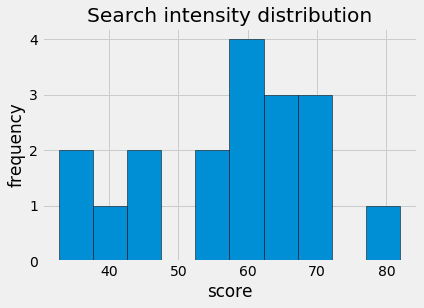

In [43]:
#setting up the look of the plot
plt.style.use('fivethirtyeight') #picking a style
plt.title('Search intensity distribution')
plt.xlabel('score')
plt.ylabel('frequency')

#creating an histogram 
plt.hist(potential_locations['search_score'], edgecolor='black')

plt.show

In [44]:
potential_locations['search_score'].describe() #getting a statistical overview of the data

count    18.000000
mean     57.102778
std      12.952980
min      32.760000
25%      47.752500
50%      60.060000
75%      64.050000
max      82.000000
Name: search_score, dtype: float64

In [45]:
potential_locations.shape

(18, 5)

<h4> Creating a shortlist </h4>
<p> To create a short list we'll only take the cities whose search score is above average. </p>

In [46]:
search_filter=(potential_locations['search_score']>60.06) #the 60.06 valye was derived from the .describe step above
potential_locations=potential_locations[search_filter]
potential_locations.shape

(8, 5)

In [47]:
potential_locations.reset_index(inplace=True, drop=True)

In [48]:
#to view the results we'll plot them on the map again

#creating an empty map first
short_map=folium.Map(location=[cali_lat, cali_long], zoom_start=6, tiles='Stamen Terrain')
#adding locations to the map
for lat, long, name, pop in zip(potential_locations['latitude'], potential_locations['longitude'], potential_locations['location'], potential_locations['population']):
    label='{}, population: {}'.format(name,pop)
    label= folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill= True, 
    parse_html=False).add_to(short_map)
    
short_map

In [49]:







#say something about the map maybe






<h1> Exploring locations </h1>

<p>Now that we have a shortlist, we can dive into more details of each location. As a general rule, we know that cities tend to have clusters of restaurants and that restaurants that are located in these areas tend to do better than those that aren't. <p> </p>

Therefore we would need to find a city that has one of these clusters and then explore it further to determine what kind of restaurants are already there.  Ideally, we would like to find a place that has a decent-size cluster but that doesn't have too many pizza places already in there. To identify the clusters we need to explore each city in full, and for this purpose, Open Street Map's Overpass API is the ideal tool.  This tool, while not providing a full detailed list of restaurants does allow users to explore large areas and will be sufficient to identify the clusters. <p> </p>

Once they are identified we will shortlist the most promising clusters and use FourSquare's API to study each cluster in more detail. </p>

In [50]:
potential_locations.head(20)

location  population   latitude   longitude  search_score
0     Bakersfield    347483.0  35.373871 -119.019464         82.00
1       Riverside    303871.0  33.953355 -117.396162         68.64
2      Sacramento    466488.0  38.581572 -121.494400         62.30
3  San Bernardino    209924.0  34.825302 -116.083314         68.64
4     Chula Vista    243916.0  32.640054 -117.084196         63.96
5       San Diego   1307402.0  32.717421 -117.162771         62.40
6        Stockton    291707.0  37.957702 -121.290780         64.08
7         Modesto    201165.0  37.639097 -120.996878         68.53

In [51]:
#creating an empty dataframe to store the list of all the food places present in our shortlisted locations

food_places= pd.DataFrame(columns=['city_name','place_name','cuisine','place_latitude','place_longitude','place_id'])
food_places.head()

Empty DataFrame
Columns: [city_name, place_name, cuisine, place_latitude, place_longitude, place_id]
Index: []

In [52]:
geolocator = Nominatim(user_agent="Food_finder") #setting up geolocator
overpass_url = "http://overpass-api.de/api/interpreter" 

#creating a loop to get the data. Fore more info on using OSM's API see: https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0

for city in potential_locations['location']:

    overpass_query = """[out:json] [timeout:120]; 
    ( area[name="{}"]; )->.small;
    ( area[name="California"]; )->.big;
    (
      nwr
        ["amenity"~"restaurant",i] (area.small)(area.big);
    );
    out center;
    """.format(city)
    response = requests.get(overpass_url, params={'data': overpass_query}) #executing the query
    data=response.json()                                                   #extracting data from the response
    temp_df=pd.json_normalize(data['elements'])                            #creating a temporary dataframe with the results 
    temp_df.dropna(subset=['tags.amenity'], inplace=True)                  #dropping nodes not associated with an amenity (i.e that are not restaurants or fast foods)
    temp_df['lat'].fillna(temp_df['center.lat'], inplace=True)             #in some cases the coordinates are in a different columns and the NaN values must be corrected
    temp_df['lon'].fillna(temp_df['center.lon'], inplace=True)
    
    
    clean_df=temp_df[['tags.name','tags.cuisine','lat','lon','id']].copy() #making a copy of the temporay df with only the columns we need
    clean_df.columns=['place_name','cuisine','place_latitude','place_longitude','place_id'] #renaming the columns to match the food places dataframe
    clean_df['city_name']=city                                             #adding the city name columns to match the food places dataframe
    
    food_places=pd.concat([food_places,clean_df], ignore_index=True) #adding the results to the food places dataframe
    
    time.sleep(300) #I have added a 30 seconds delay between API calls in an attemp to not overload the API and avoid rate limiting
    
food_places.head()

city_name                     place_name      cuisine  place_latitude  \
0  Bakersfield                            NaN         thai       35.337308   
1  Bakersfield       Hungry Hunter Steakhouse  steak_house       35.383949   
2  Bakersfield                 Nuestro México      mexican       35.378264   
3  Bakersfield           Hong Kong Restaurant      chinese       35.363490   
4  Bakersfield  Camino Real Kitchen & Tequila      mexican       35.313867   

   place_longitude    place_id  
0      -119.059970  1577564359  
1      -119.047469  4467277390  
2      -119.010093  4955903568  
3      -119.019136  5927785302  
4      -119.057065  6579414020

In [53]:
food_places.shape

(1405, 6)

In [54]:
#to view the results we'll plot them on the map again

#creating an empty map first
food_map=folium.Map(location=[cali_lat, cali_long], zoom_start=6, tiles='Stamen Terrain')
#adding locations to the map
for lat, long, name, cuisine in zip(food_places['place_latitude'],food_places['place_longitude'],food_places['place_name'],food_places['cuisine']):
    label='{}'.format(name,cuisine)
    label= folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill= True, 
    parse_html=False).add_to(food_map)
    
food_map

<h3> Visualizing restaurants by city </h3>

<h4> Bakersfield </h4>

In [55]:
temp_filt = food_places['city_name'] == 'Bakersfield' #creating a temporary filter to get just the restaurants from barkersfield
Bakersfield_restaurants = food_places[temp_filt] #filtering 

In [56]:
Bakersfield_restaurants.shape

(119, 6)

In [57]:
Bakersfield_lat=potential_locations.at[0,'latitude']  #extracting latitude and longitude from our df
Bakersfield_lon=potential_locations.at[0,'longitude']

Bakersfield_map=folium.Map(location=[Bakersfield_lat, Bakersfield_lon], zoom_start=11, tiles='Stamen Terrain') #creating a blank map

for lat, long, name, cuisine in zip(Bakersfield_restaurants['place_latitude'],Bakersfield_restaurants['place_longitude'],Bakersfield_restaurants['place_name'],Bakersfield_restaurants['cuisine']):
    label='{}'.format(name,cuisine)
    label= folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill= True, 
    parse_html=False).add_to(Bakersfield_map)
    
Bakersfield_map

<h4> Riverside </h4>

In [58]:
temp_filt = food_places['city_name'] == 'Riverside' #creating a temporary filter to get just the restaurants from barkersfield
Riverside_restaurants = food_places[temp_filt] #filtering 

In [59]:
Riverside_restaurants.shape

(65, 6)

In [60]:
Riverside_lat=potential_locations.at[1,'latitude']  #extracting latitude and longitude from our df
Riverside_lon=potential_locations.at[1,'longitude']

Riverside_map=folium.Map(location=[Riverside_lat, Riverside_lon], zoom_start=11, tiles='Stamen Terrain') #creating a blank map

for lat, long, name, cuisine in zip(Riverside_restaurants['place_latitude'],Riverside_restaurants['place_longitude'],Riverside_restaurants['place_name'],Riverside_restaurants['cuisine']):
    label='{}'.format(name,cuisine)
    label= folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill= True, 
    parse_html=False).add_to(Riverside_map)
    
Riverside_map

<h4> Sacramento </h4>

In [61]:
temp_filt = food_places['city_name'] == 'Sacramento' #creating a temporary filter to get just the restaurants from barkersfield
Sacramento_restaurants = food_places[temp_filt] #filtering 

In [62]:
Sacramento_restaurants.shape

(231, 6)

In [63]:
Sacramento_lat=potential_locations.at[2,'latitude']  #extracting latitude and longitude from our df
Sacramento_lon=potential_locations.at[2,'longitude']

Sacramento_map=folium.Map(location=[Sacramento_lat, Sacramento_lon], zoom_start=12, tiles='Stamen Terrain') #creating a blank map

for lat, long, name, cuisine in zip(Sacramento_restaurants['place_latitude'],Sacramento_restaurants['place_longitude'],Sacramento_restaurants['place_name'],Sacramento_restaurants['cuisine']):
    label='{}'.format(name,cuisine)
    label= folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill= True, 
    parse_html=False).add_to(Sacramento_map)
    
Sacramento_map

<h4> San Bernardino </h4>

In [64]:
temp_filt = food_places['city_name'] == 'San Bernardino' #creating a temporary filter to get just the restaurants from barkersfield
SanBernardino_restaurants = food_places[temp_filt] #filtering 

In [65]:
SanBernardino_restaurants.shape

(40, 6)

In [66]:
SanBernardino_lat=potential_locations.at[3,'latitude']  #extracting latitude and longitude from our df
SanBernardino_lon=potential_locations.at[3,'longitude']

SanBernardino_map=folium.Map(location=[SanBernardino_lat, SanBernardino_lon], zoom_start=11, tiles='Stamen Terrain') #creating a blank map

for lat, long, name, cuisine in zip(SanBernardino_restaurants['place_latitude'],SanBernardino_restaurants['place_longitude'],SanBernardino_restaurants['place_name'],SanBernardino_restaurants['cuisine']):
    label='{}'.format(name,cuisine)
    label= folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill= True, 
    parse_html=False).add_to(SanBernardino_map)
    
SanBernardino_map

<h4> Chula Vista </h4>

In [67]:
temp_filt = food_places['city_name'] == 'Chula Vista' #creating a temporary filter to get just the restaurants from barkersfield
ChulaVista_restaurants = food_places[temp_filt] #filtering 

In [68]:
ChulaVista_restaurants.shape

(64, 6)

In [69]:
ChulaVista_lat=potential_locations.at[4,'latitude']  #extracting latitude and longitude from our df
ChulaVista_lon=potential_locations.at[4,'longitude']

ChulaVista_map=folium.Map(location=[ChulaVista_lat, ChulaVista_lon], zoom_start=11, tiles='Stamen Terrain') #creating a blank map

for lat, long, name, cuisine in zip(ChulaVista_restaurants['place_latitude'],ChulaVista_restaurants['place_longitude'],ChulaVista_restaurants['place_name'],ChulaVista_restaurants['cuisine']):
    label='{}'.format(name,cuisine)
    label= folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill= True, 
    parse_html=False).add_to(ChulaVista_map)
    
ChulaVista_map

<h4> San Diego </h4>

In [70]:
temp_filt = food_places['city_name'] == 'San Diego' #creating a temporary filter to get just the restaurants from barkersfield
SanDiego_restaurants = food_places[temp_filt] #filtering 

In [71]:
SanDiego_restaurants.shape

(821, 6)

In [72]:
SanDiego_lat=potential_locations.at[5,'latitude']  #extracting latitude and longitude from our df
SanDiego_lon=potential_locations.at[5,'longitude']

SanDiego_map=folium.Map(location=[SanDiego_lat, SanDiego_lon], zoom_start=11, tiles='Stamen Terrain') #creating a blank map

for lat, long, name, cuisine in zip(SanDiego_restaurants['place_latitude'],SanDiego_restaurants['place_longitude'],SanDiego_restaurants['place_name'],SanDiego_restaurants['cuisine']):
    label='{}'.format(name,cuisine)
    label= folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill= True, 
    parse_html=False).add_to(SanDiego_map)
    
SanDiego_map

<h4> Stockton </h4>

In [73]:
temp_filt = food_places['city_name'] == 'Stockton' #creating a temporary filter to get just the restaurants from barkersfield
Stockton_restaurants = food_places[temp_filt] #filtering 

In [74]:
Stockton_restaurants.shape

(41, 6)

In [75]:
Stockton_lat=potential_locations.at[6,'latitude']  #extracting latitude and longitude from our df
Stockton_lon=potential_locations.at[6,'longitude']

Stockton_map=folium.Map(location=[Stockton_lat, Stockton_lon], zoom_start=11, tiles='Stamen Terrain') #creating a blank map

for lat, long, name, cuisine in zip(Stockton_restaurants['place_latitude'],Stockton_restaurants['place_longitude'],Stockton_restaurants['place_name'],Stockton_restaurants['cuisine']):
    label='{}'.format(name,cuisine)
    label= folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill= True, 
    parse_html=False).add_to(Stockton_map)
    
Stockton_map

<h4> Modesto </h4>

In [76]:
temp_filt = food_places['city_name'] == 'Modesto' #creating a temporary filter to get just the restaurants from barkersfield
Modesto_restaurants = food_places[temp_filt] #filtering 

In [77]:
Modesto_restaurants.shape

(24, 6)

In [78]:
Modesto_lat=potential_locations.at[7,'latitude']  #extracting latitude and longitude from our df
Modesto_lon=potential_locations.at[7,'longitude']

Modesto_map=folium.Map(location=[Modesto_lat, Modesto_lon], zoom_start=11, tiles='Stamen Terrain') #creating a blank map

for lat, long, name, cuisine in zip(Modesto_restaurants['place_latitude'],Modesto_restaurants['place_longitude'],Modesto_restaurants['place_name'],Modesto_restaurants['cuisine']):
    label='{}'.format(name,cuisine)
    label= folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lat,long],
    radius=5,
    popup=label,
    color='blue',
    fill= True, 
    parse_html=False).add_to(Modesto_map)
    
Modesto_map

<h3> Calculating resaturant density </h3>

In [79]:
restaurant_count = pd.DataFrame(food_places['city_name'].value_counts().reset_index()) #counting restaurants
restaurant_count.rename(columns={'index':'city_name', 'city_name':'total_restaurants'}, inplace=True) #renaming columns
restaurant_count.head(10)

city_name  total_restaurants
0       San Diego                821
1      Sacramento                231
2     Bakersfield                119
3       Riverside                 65
4     Chula Vista                 64
5        Stockton                 41
6  San Bernardino                 40
7         Modesto                 24

In [80]:
potential_locations=pd.merge(restaurant_count, potential_locations, left_on='city_name', right_on='location')
potential_locations.drop(columns=['location'],inplace=True)
potential_locations.head(10)

city_name  total_restaurants  population   latitude   longitude  \
0       San Diego                821   1307402.0  32.717421 -117.162771   
1      Sacramento                231    466488.0  38.581572 -121.494400   
2     Bakersfield                119    347483.0  35.373871 -119.019464   
3       Riverside                 65    303871.0  33.953355 -117.396162   
4     Chula Vista                 64    243916.0  32.640054 -117.084196   
5        Stockton                 41    291707.0  37.957702 -121.290780   
6  San Bernardino                 40    209924.0  34.825302 -116.083314   
7         Modesto                 24    201165.0  37.639097 -120.996878   

   search_score  
0         62.40  
1         62.30  
2         82.00  
3         68.64  
4         63.96  
5         64.08  
6         68.64  
7         68.53

In [81]:
potential_locations['restaurants_pp'] =  potential_locations['total_restaurants']/potential_locations['population']
potential_locations.head(10)

city_name  total_restaurants  population   latitude   longitude  \
0       San Diego                821   1307402.0  32.717421 -117.162771   
1      Sacramento                231    466488.0  38.581572 -121.494400   
2     Bakersfield                119    347483.0  35.373871 -119.019464   
3       Riverside                 65    303871.0  33.953355 -117.396162   
4     Chula Vista                 64    243916.0  32.640054 -117.084196   
5        Stockton                 41    291707.0  37.957702 -121.290780   
6  San Bernardino                 40    209924.0  34.825302 -116.083314   
7         Modesto                 24    201165.0  37.639097 -120.996878   

   search_score  restaurants_pp  
0         62.40        0.000628  
1         62.30        0.000495  
2         82.00        0.000342  
3         68.64        0.000214  
4         63.96        0.000262  
5         64.08        0.000141  
6         68.64        0.000191  
7         68.53        0.000119

<function matplotlib.pyplot.show(*args, **kw)>

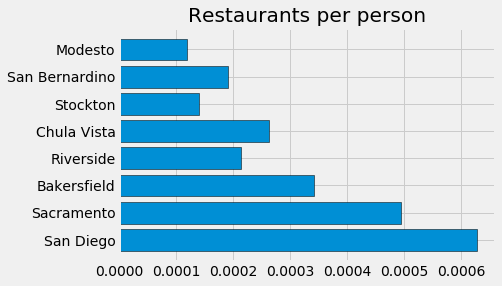

In [82]:
#setting up the look of the plot
plt.style.use('fivethirtyeight') #picking a style
plt.title('Restaurants per person')

#creating an histogram 
plt.barh(potential_locations['city_name'], potential_locations['restaurants_pp'], edgecolor='black')

plt.show

<h3> Qualitative analysis </h3>

<p> As mentioned earlier for a restaurant to thrive it should ideally be located near a cluster of other restaurants that might attract clients.  Looking at the maps above some cities like Sacramento, stand out for having clearly defined clusters. As the first step in this qualitative stage of the filtering process, we'll rule out the cities of Modesto, Riverside and Bakersfield since their restaurants appear to be very spread out in the city and do not have clear clusters. This leaves us with Sacramento, San Bernardino, Chula Vista, San Diego and Stockton. </p><p>

Of these, the cities of San Bernardino and Stockton have the lowest number of restaurants per inhabitant. This could be interpreted both as an opportunity and as a sign of weak local demand.  Looking at the map in more detail we can see that in Stockton the restaurants aren't very well clustered and tend to line up with two main roads, which could suggest a less-than-lively local scene. The same is true for San Bernardino and Chula vista</p><p>

If we rule out these cities we are left with two contenders, San Diego and Sacramento.  Both have a high concentration of restaurants and what appears to be multiple clusters of restaurants that could serve as potential locations for the new pizza place.To understand them better we'll first use machine learning to identify the centre of the clusters and then investigate them in more detail with the FourSquare API.<p>

<h1> Comparing neighbourhoods </h1>

<p>Now that we have our two city contenders, San Diego and Sacramento, it is time to dive deeper and identify which neighbourhoods are hotspots for restaurants in each city and use them to determine the best place to open the pizza place. </p><p>

However, since traditional neighbourhoods borders are sometimes shaped by historical factors and not by the characteristics of each area we'll use a different system based on identifying clusters with machine learning and then using the centre of each cluster and a radius as the definition of each area.</p> 

<h2> Cluster identification </h2>

<p>To choose the best algorithm we need an algorithm that is capable of finding high-density areas and ignore items that aren't part of them. This is because many restaurants are isolated from the rest and effectively act as noise in the data. <p></p>

K-means is therefore not a suitable option since it is too heavily influenced by noise. Mean Shift, on the other hand, appears to be a better tool, especially if used in conjunction with a heat-map that will help validate the viability of each cluster. </p>


<h3> Sacramento </h3>

In [83]:
Sacramento_restaurants.reset_index(inplace=True, drop=True)
Sacramento_restaurants.head()

city_name                         place_name   cuisine  place_latitude  \
0  Sacramento                        Jim Denny's    burger       38.581194   
1  Sacramento                    The Squeeze Inn    burger       38.526933   
2  Sacramento                  Upper Crust Pizza     pizza       38.578130   
3  Sacramento  Regent Chinese Seafood Restaurant       NaN       38.485526   
4  Sacramento                            Shari's  american       38.495297   

   place_longitude   place_id  
0      -121.490298  368158458  
1      -121.408570  439041879  
2      -121.490495  669131354  
3      -121.533822  761844001  
4      -121.522457  761845538

In [84]:
#starting by aplying Mean Shift to the coordinates of Sacramento's restaurants
ms=MeanShift(bandwidth=0.02,cluster_all=False)

Sacramento_X = Sacramento_restaurants[['place_latitude','place_longitude']].to_numpy() #converting the coordinates to a numpy array to allow the algorithm to process them
ms.fit(Sacramento_X)  #running the algorithm 

Sacramento_clusters=ms.cluster_centers_ #extracting the coordinates of cluster centers
Sacramento_clusters #outputting the cluster centers

array([[  38.56937754, -121.48692441],
       [  38.64150648, -121.5046708 ],
       [  38.5351036 , -121.49558166],
       [  38.61684448, -121.48587232],
       [  38.55752084, -121.43429588],
       [  38.59946694, -121.4267399 ],
       [  38.48789421, -121.52039138],
       [  38.50935438, -121.5416438 ],
       [  38.45519485, -121.41453475],
       [  38.6456249 , -121.4573885 ],
       [  38.5269329 , -121.40857   ],
       [  38.5165058 , -121.4380209 ],
       [  38.4954446 , -121.4787284 ],
       [  38.4753832 , -121.4480191 ],
       [  38.4648128 , -121.4931367 ]])

In [85]:
#creating labels for each point
Sac_lables=[]

for point in range(len( Sacramento_clusters)):
    label='Sac_{}'.format(point)
    Sac_lables.append(label)
    
Sac_lables

['Sac_0',
 'Sac_1',
 'Sac_2',
 'Sac_3',
 'Sac_4',
 'Sac_5',
 'Sac_6',
 'Sac_7',
 'Sac_8',
 'Sac_9',
 'Sac_10',
 'Sac_11',
 'Sac_12',
 'Sac_13',
 'Sac_14']

In [86]:
Sac_MS=pd.DataFrame({'label':Sac_lables, 'latitude':Sacramento_clusters[:,0], 'longitude':Sacramento_clusters[:,1]})     
Sac_MS.head()

label   latitude   longitude
0  Sac_0  38.569378 -121.486924
1  Sac_1  38.641506 -121.504671
2  Sac_2  38.535104 -121.495582
3  Sac_3  38.616844 -121.485872
4  Sac_4  38.557521 -121.434296

In [87]:
#creating a blank map
Sac_MS_map=folium.Map(location=[Sacramento_lat, Sacramento_lon],control_scale=True, zoom_start=12, tiles='Stamen Terrain') 

#adding the cluster centers
for lat, long, lbl in zip(Sac_MS['latitude'], Sac_MS['longitude'],Sac_MS['label']):
    folium.CircleMarker(
    [lat,long],
    radius=8,
    color='red',
    fill= True,
    popup=lbl,
    label=lbl,
    parse_html=False).add_to(Sac_MS_map)
    
#adding the heatmap derived from the locations of all restaurants

HeatMap( data=Sacramento_restaurants[['place_latitude','place_longitude']].values.tolist(),
        radius=15
       ).add_to(Sac_MS_map)
    
Sac_MS_map



<p> Looking at the map we can see that Sac_0 appears to be the most promising area, followeed by Sac_2 </p>

<h3> San Diego </h3>

In [88]:
SanDiego_restaurants.reset_index(inplace=True, drop=True)
SanDiego_restaurants.head()

city_name        place_name  cuisine  place_latitude  place_longitude  \
0  San Diego          Leucadia  italian       32.862323      -117.224694   
1  San Diego         Subarashi    sushi       32.862046      -117.224690   
2  San Diego     Thai Time III     thai       32.821390      -117.183779   
3  San Diego  Sipz Fusion Cafe    vegan       32.833644      -117.173862   
4  San Diego     Shanghai Cafe  chinese       32.862689      -117.224432   

    place_id  
0  273607070  
1  273607369  
2  274193511  
3  274363369  
4  276540072

In [89]:
#starting by aplying Mean Shift to the coordinates of Sacramento's restaurants
ms=MeanShift(bandwidth=0.02,cluster_all=False)

SanDiego_X = SanDiego_restaurants[['place_latitude','place_longitude']].to_numpy() #converting the coordinates to a numpy array to allow the algorithm to process them
ms.fit(SanDiego_X)  #running the algorithm 

SanDiego_clusters=ms.cluster_centers_ #extracting the coordinates of cluster centers


In [90]:
#creating labels for each point
SD_lables=[]

for point in range(len( SanDiego_clusters)):
    label='SD_{}'.format(point)
    SD_lables.append(label)
    


In [91]:
SD_MS=pd.DataFrame({'label':SD_lables, 'latitude':SanDiego_clusters[:,0], 'longitude':SanDiego_clusters[:,1]})     
SD_MS.head()

label   latitude   longitude
0  SD_0  32.716233 -117.164621
1  SD_1  32.754667 -117.147377
2  SD_2  32.749573 -117.205504
3  SD_3  32.824585 -117.165919
4  SD_4  32.867066 -117.215628

In [92]:
#creating a blank map
SD_MS_map=folium.Map(location=[SanDiego_lat, SanDiego_lon],control_scale=True, zoom_start=12, tiles='Stamen Terrain') 

#adding the cluster centers
for lat, long, lbl in zip(SD_MS['latitude'], SD_MS['longitude'],SD_MS['label']):
    folium.CircleMarker(
    [lat,long],
    radius=8,
    color='red',
    fill= True,
    popup=lbl,
    label=lbl,
    parse_html=False).add_to(SD_MS_map)
    
#adding the heatmap derived from the locations of all restaurants

HeatMap( data=SanDiego_restaurants[['place_latitude','place_longitude']].values.tolist(),
        radius=15
       ).add_to(SD_MS_map)
    
SD_MS_map

<p> Exploring the the map above we can select the following as the most promisig spots: SD_0, SD_1, SD_2 ,SD_4, SD_5, SD_6, SD_7 </p> 
    
<h3> Shortlisted Locations </h3>

In [93]:
keep=['Sac_0','Sac_2'] #listing the locations we want to keep

filt= Sac_MS['label'].isin(keep) #creating a filter

Sac_shortlist=Sac_MS[filt] #filtering the dataframe to keep only the selected locations
Sac_shortlist.head()

label   latitude   longitude
0  Sac_0  38.569378 -121.486924
2  Sac_2  38.535104 -121.495582

In [94]:
keep=[ 'SD_0', 'SD_1', 'SD_2' ,'SD_4', 'SD_5', 'SD_6', 'SD_7'] #repeating the process for SanDiego
filt= SD_MS['label'].isin(keep)
SD_shortlist=SD_MS[filt]
SD_shortlist.head()

label   latitude   longitude
0  SD_0  32.716233 -117.164621
1  SD_1  32.754667 -117.147377
2  SD_2  32.749573 -117.205504
4  SD_4  32.867066 -117.215628
5  SD_5  32.796379 -117.250457

In [95]:
shortlist=pd.concat([Sac_shortlist,SD_shortlist])
shortlist.reset_index(inplace=True, drop=True)
shortlist.head()

label   latitude   longitude
0  Sac_0  38.569378 -121.486924
1  Sac_2  38.535104 -121.495582
2   SD_0  32.716233 -117.164621
3   SD_1  32.754667 -117.147377
4   SD_2  32.749573 -117.205504

<h2> Foursquare search </h2>

<p> Now that we have a final list of "neighbourhoods" to explore it is time to use the FourSquare API to understand how intense the competition is in each area.  </p>

In [96]:
#this bit shouldn't change
CLIENT_ID = 'PLWEMRRH0RFT513QPZG322L5VKIMIPEYJ30J4FXE2KPRC3DI' # your Foursquare ID
CLIENT_SECRET = '32QAIB1ZN4KJLRCMXNE5WSN43WBTXIGPOSMXODA2AS2IUJNC' # your Foursquare Secret
VERSION = '20180604'


In [97]:
competition_intensity = []  #this will store the number of pizza places found in a 1.5km radius 

search_query= 'pizza'
radius= 1500

for lat, lon in zip(shortlist['latitude'], shortlist['longitude']):
    latitude=lat
    longitude=lon
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&intent=browse&ll={},{}&query={}&radius={}&v={}&limit=100'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, search_query, radius, VERSION)
    results = requests.get(url).json()
    competition_intensity.append(len((results ['response'] ['venues'])))

shortlist['competition_intensity']=competition_intensity
shortlist.sort_values(by=['competition_intensity'], ascending=False, inplace=True )   
shortlist.head(10)

label   latitude   longitude  competition_intensity
2   SD_0  32.716233 -117.164621                     38
6   SD_5  32.796379 -117.250457                     24
5   SD_4  32.867066 -117.215628                     16
0  Sac_0  38.569378 -121.486924                     15
4   SD_2  32.749573 -117.205504                     14
3   SD_1  32.754667 -117.147377                     13
8   SD_7  32.841568 -117.274516                      8
7   SD_6  32.747568 -117.247702                      6
1  Sac_2  38.535104 -121.495582                      3

<function matplotlib.pyplot.show(*args, **kw)>

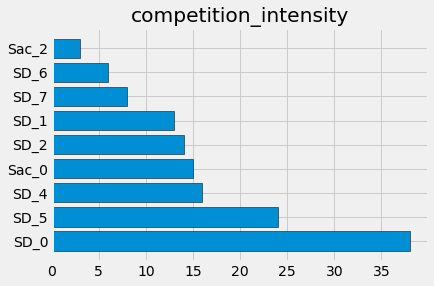

In [98]:
#setting up the look of the plot
plt.style.use('fivethirtyeight') #picking a style
plt.title('competition_intensity')

#creating an histogram 
plt.barh(shortlist['label'], shortlist['competition_intensity'], edgecolor='black')

plt.show

<h3> Analyzing the final 7 </h3>

<p> Looking at the data above it is clear that two of the areas are already oversaturated with pizza places and can be dropped. The remaining ones look promising but more data is needed to understand exactly how the pizza spots fit in the local food scene.</p>

In [99]:
shortlist.set_index('label', drop=True, inplace=True)

In [100]:
shortlist.drop(index='SD_0', inplace=True)
shortlist.drop(index='SD_5', inplace=True)

shortlist.head(10)

latitude   longitude  competition_intensity
label                                              
SD_4   32.867066 -117.215628                     16
Sac_0  38.569378 -121.486924                     15
SD_2   32.749573 -117.205504                     14
SD_1   32.754667 -117.147377                     13
SD_7   32.841568 -117.274516                      8
SD_6   32.747568 -117.247702                      6
Sac_2  38.535104 -121.495582                      3

In [153]:
shortlist.reset_index(inplace=True)
shortlist.head()

label   latitude   longitude  competition_intensity
0   SD_4  32.867066 -117.215628                     16
1  Sac_0  38.569378 -121.486924                     15
2   SD_2  32.749573 -117.205504                     14
3   SD_1  32.754667 -117.147377                     13
4   SD_7  32.841568 -117.274516                      8

<h4> Getting around FourSquare's limitations </h4>

<p>To get a clear idea of what can be found in each area we need to obtain a full list of all the eating establishment that can be found in a range of 1km from the centre of each area. </p>

<p>The challenge is that FourSquare's API can only return a maximum of 50 items per search. This means that if we were to query it for all the food places found within 1 km it would return a list of 50 items, but it would be an incomplete list.   After some trials, I have determined that, in the densest areas, the maximum search range to get a complete list of results is 500 meters. If we convert this radius to an area we quickly discover that a circle of range 500 has only a quarter of the area of one of range 1000 and gives us a very limited search area. </p>

<p>To get around the problem I have created a function that returns a series of 6 points each offset 500m in latitude and/or in longitude. Conducting separate searches of radius 500 on each of these points, combining them and discarding duplicate locations gives us a full picture of the 1000m area we wanted to search plus some extra bits. </p>

In [142]:
def box_offset (lat, lon):
    
    #PART 1 : INITIALIZING ----------------------------------------------------------------------------------------------------    
    Original_point=(lat, lon) #our starting point is the same as the input
    names=[]       #this will store the names of the new points
    latitudes=[]   #this will store the latitudes of the new points
    longitudes=[]  #this will store the longitudes of the new points
    EW_distance=0  #initializing a distance parameter that will be use to check how far each iteration is from the original point (measured in km)
    EW_lon=lon  #the function will look for a point that is .5 km from the original along the EeastWest (longitude) axis, the variable is initialized here with the original longiude
    
    #PART 2 : CALCULATING THE TWO POINTS ON THE EAST-WEST AXIS (aka horizontal, aka, longitudinal)------------------------------
    while EW_distance < 0.5:  #this while loop will end when the distance from the original point to the new one is 0.5 km 
        EW_new_point=(lat, EW_lon)
        EW_distance= distance.distance(Original_point, EW_new_point).km   #this line calculates the distance between the old point and the new one
        EW_lon=EW_lon+0.00005
    EW_lon_offset = lon - EW_lon #calculating by how much we had to change the longitude to get a point 0.5km away
        
    names.append('E_point')    #appending the Eastern point
    latitudes.append(lat)
    longitudes.append(lon + EW_lon_offset) #the new longitude of the point due EAST from the origin is calculated by ADDING the offset to it
    
    names.append('W_point')     #appending the Western point
    latitudes.append(lat)
    longitudes.append(lon - EW_lon_offset) #the new longitude of the point due WEST from the origin is calculated by SUBTRACTING the offset to it
    
    #PART 3 : REPEATING THE PROCESS FOR THE NORTH-SOUTH AXIS------------------------------------------------------------------
    NS_distance=0
    NS_lat=lat
    
    while NS_distance < 0.5:
        NS_new_point=(NS_lat, lon)  #this time we are changing the latitude instead of the longitude 
        NS_distance = distance.distance(Original_point, NS_new_point).km
        NS_lat=NS_lat+0.00005
    NS_lat_offset = lat - NS_lat
        
    names.append('N_point')    #appending the Northen point
    latitudes.append(lat + NS_lat_offset)
    longitudes.append(lon)
    
    names.append('S_point')    #appending the Southern point
    latitudes.append(lat - NS_lat_offset)
    longitudes.append(lon)
    
    #PART 4 : COMBINGING NS and EW OFFSETS TO GET THE OTHER POINTS---------------------------------------------------------------
    names.append('NE_point')    
    latitudes.append(lat + NS_lat_offset)
    longitudes.append(lon + EW_lon_offset)
    
    names.append('NW_point')    
    latitudes.append(lat + NS_lat_offset)
    longitudes.append(lon - EW_lon_offset)
    
    names.append('SE_point')    
    latitudes.append(lat - NS_lat_offset)
    longitudes.append(lon + EW_lon_offset)
    
    names.append('SW_point')    
    latitudes.append(lat - NS_lat_offset)
    longitudes.append(lon - EW_lon_offset)
    
    #PART 5 : OUTPUTTING AS A DATAFRAME ----------------------------------------------------------------------------------------
    temp_df=pd.DataFrame({'name':names, 'latitude':latitudes, 'longitude':longitudes })
    return temp_df
        

Having defined the function it is now time to use it on the shortlisted locations

In [195]:
#QUICK DICTIONARY:
    #SHORTLISTED AREA = these are the 7 areas that we shortlisted earlier 
    #SEARCH POINTS = these are the points that are returned by the function, when combined they will cover all of the shortlisted area
    
#creating variables store the results
area_code = []
area_venues_name = []  
area_venues_category = []
area_venues_lat = []
area_venues_lon = []
area_venues_id =[]

for label, lat, lon in zip (shortlist['label'],shortlist['latitude'],shortlist['longitude'] ):
    
    #STEP 1: applying the box_offset function to each SHORTLISTED AREA
    search_points = box_offset(lat,lon) #this will return a dataframe with the new search points
        
    #STEP 2: running a 4SQ API query for each of the search points
    for LAT, LON in zip (search_points['latitude'], search_points['longitude']):
        category_id='4d4b7105d754a06374d81259' #this is the code for all eating establishments in 4SQ API
        radius=500
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&intent=browse&ll={},{}&categoryId={}&radius={}&v={}&limit=100'.format(CLIENT_ID, CLIENT_SECRET, LAT, LON, category_id, radius, VERSION)
        results = requests.get(url).json() 
              
        for i in range (len((results ['response'] ['venues']))): #going through the results of the search to extract the info we need
            area_venues_name.append(results['response'] ['venues'] [i] ['name'])
            area_venues_id.append(results['response'] ['venues'] [i] ['id'])
            area_venues_category.append(results['response'] ['venues'] [i] ['categories'] [0] ['name'])
            area_venues_lat.append(results['response'] ['venues'] [i] ['location'] ['lat'])
            area_venues_lon.append(results['response'] ['venues'] [i] ['location'] ['lng'])
            area_code.append(label)
        
#storing the results in a dataframe
all_venues=pd.DataFrame({'area_name':area_code, 'venue_name':area_venues_name, 'venue_category':area_venues_category, 'venue_latitude':area_venues_lat, 'venue_longitude':area_venues_lon,'venue_id':area_venues_id })

#removing duplicates
all_venues.drop_duplicates(subset='venue_id', inplace=True,ignore_index=True)
     
all_venues.head()

area_name                             venue_name venue_category  \
0      SD_4                         Pomodoro Rosso     Food Truck   
1      SD_4                  Restaurants Unlimited           Food   
2      SD_4                      Tocaya - La Jolla     Restaurant   
3      SD_4                Aquarella Mexican Grill           Food   
4      SD_4  Fleming's Prime Steakhouse & Wine Bar     Steakhouse   

   venue_latitude  venue_longitude                  venue_id  
0       32.869721      -117.222641  5760b117cd106a2132c5004e  
1       32.870503      -117.224362  4f326be519836c91c7d631ec  
2       32.864426      -117.222767  5e5a470ef68b7d0008c13af0  
3       32.869932      -117.224516  4f322d3f19836c91c7bdb666  
4       32.870409      -117.224483  40e0b100f964a52028021fe3

In [203]:
all_venues.shape

(1092, 6)

<h4> Filtering irrelevant catergories </h4>
<p>FourSquare groups into its "food" category many places that aren't potential competitors for a pizza place. In this step, we'll filter out any category name that starts with "shop" (Coffee Shops, Juice Shops etc.) as well as bakeries, cafeterias and cafés. </p>

In [204]:
shops_filter=~all_venues['venue_category'].str.contains('Shop') #creating a filter to eliminate rows where the category contains the word Shop 
all_venues=all_venues[shops_filter]
all_venues.shape

(906, 6)

In [205]:
Cafe_filter=~all_venues['venue_category'].str.contains('Café') #creating a filter to eliminate rows where the category contains the word Café 
all_venues=all_venues[Cafe_filter]
all_venues.shape

(846, 6)

In [206]:
Bakery_filter=~all_venues['venue_category'].str.contains('Bakery') #creating a filter to eliminate rows where the category contains the word Bakery 
all_venues=all_venues[Bakery_filter]
all_venues.shape

(824, 6)

In [207]:
Cafeteria_filter=~all_venues['venue_category'].str.contains('Cafeteria') #creating a filter to eliminate rows where the category contains the word Cafeteria 
all_venues=all_venues[Cafeteria_filter]
all_venues.shape

(821, 6)

In [216]:
len(all_venues.index)

821

<h4> Comparing areas </h4>

In [202]:
by_area = all_venues.groupby(['area_name'])  #creating a filter to view results by area 

In [224]:
area_code = []
food_places = []
pizza_places = []
latitude = []
longitude = []

for area, lat, lon in zip(shortlist['label'], shortlist['latitude'], shortlist['longitude']):
    area_code.append(area) 
    latitude.append(lat)
    longitude.append(lon)
    
    restaurant_filter=all_venues['area_name'].str.contains(area)
    temp_df=all_venues[restaurant_filter]
    food_places.append(len(temp_df))
    
    pizza_filter=temp_df['venue_category'].str.contains('Pizza')
    pizza_df=temp_df[pizza_filter]
    pizza_places.append(len(pizza_df))
    
competition_data=pd.DataFrame({'area_code':area_code, 'latitude':latitude, 'longitude':longitude, 'food_places':food_places, 'pizza_places':pizza_places})

competition_data['ratio'] = (competition_data['food_places'] / competition_data['pizza_places']).round(2)

competition_data.head(10)

area_code   latitude   longitude  food_places  pizza_places  ratio
0      SD_4  32.867066 -117.215628          112             6  18.67
1     Sac_0  38.569378 -121.486924          160            13  12.31
2      SD_2  32.749573 -117.205504          157            11  14.27
3      SD_1  32.754667 -117.147377          142            11  12.91
4      SD_7  32.841568 -117.274516          127             7  18.14
5      SD_6  32.747568 -117.247702           91             5  18.20
6     Sac_2  38.535104 -121.495582           32             3  10.67

<h4> Top 3 </h4>

In [226]:
finalist_filter = competition_data['ratio'] > 18
finalists = competition_data[finalist_filter]
finalists.reset_index(inplace=True, drop=True)
finalists.head()

area_code   latitude   longitude  food_places  pizza_places  ratio
0      SD_4  32.867066 -117.215628          112             6  18.67
1      SD_7  32.841568 -117.274516          127             7  18.14
2      SD_6  32.747568 -117.247702           91             5  18.20

In [230]:
finalists['food_places'].mean()

110.0

In [235]:
#creating a blank map
lat = finalists['latitude'].mean()
lon = finalists['longitude'].mean()


finalists_map=folium.Map(location=[lat, lon],control_scale=True, zoom_start=11, tiles='Stamen Terrain') 

#adding the cluster centers
for lat, long, lbl in zip(finalists['latitude'], finalists['longitude'],finalists['area_code']):
    folium.CircleMarker(
    [lat,long],
    radius=15,
    color='blue',
    fill= True,
    popup=lbl,
    label=lbl,
    parse_html=False).add_to(finalists_map)

HeatMap( data=SanDiego_restaurants[['place_latitude','place_longitude']].values.tolist(),
        radius=20
       ).add_to(finalists_map) 

finalists_map